<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/acse-2020/acse2020-acse9-finalreport-acse-dl1420-3/blob/main/Notebook_3-Make_Predictions.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-dl1420-3/blob/main/Notebook_3-Make_Predictions.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# **Requirements**
The requirements to run this notebook are:
1. Have a @gmail account **->** here how to get one: https://support.google.com/accounts/answer/27441?hl=en
2. Have a Google Earth Engine account **->** here how to get one: https://signup.earthengine.google.com/
3. (*Optional* - see disclaimer below) Have a Google Coud Storage setup **->** here how to get one: https://cloud.google.com/storage *(please read Note 2 below)*

---
**Note**: Google Earth Engine is a free to use online tool, but it requires authorisation from Google first. After signing up, it may take a few days before being able to access the platform.

**Note 2**: Google Cloud Storage IS NOT a free tool. Like many other cloud services, it has different costs for different services. At the time of writing of this notebook, Google offers new Cloud Storage users a 90-day free trial with some funds attached to it. Please find more info at: https://cloud.google.com/free/docs/gcp-free-tier

---
**Disclaimer**: Using Google Cloud storge is only optional if the user is not interested in exporting the produced classifed image to Google Earth Engine as an asset. If instead, the user is interested in producing an asset, the use of Google Cloud Storage becomes mandatory. This is because the command line that uses the Earth Engine API expects the files to be stored in Google Cloud Storage. Please see the following link for reference: https://developers.google.com/earth-engine/guides/command_line#upload

# **Objective**

This Notebook has the purpose of generating an image composite of a target small geographical area and time, exporting the image as TFRecords patches to the target Google storage and make predictions and cross-validation.

The exported patches are classified using the choes neural network. The notebook is setup to load model pre-trained in Notebook_2 (although the user may use any relevant Keras model). The classified images **must** be exported to Google Cloud Storage if the user decieds to then export the classification as a Google Earth Engine asset.

# 1. Preparing the workspace

## Cloning the Github Repository
The github repository that stores the project is cloned to the workspace to allow accessing the needed packages.

In [ ]:
github_repo = "https://github.com/davidelomeo/mangroves_deep_learning.git"
print("Github Repository: ", github_repo)

!git clone "{github_repo}" # clone the github repository

## Installing the required packages
Although Google Colab has a pre-installed environment that contains many packages, a `requirement.txt` was provided in the GitHub repository for consistency (please see disclaimer below).

The following code also install custom packages created specifically to facilitate the reproducibility of some key parts of the worfkflow, and hence allow the user to re-use these packages in other projects.

---
**Disclaimer**: The notebook was specifically designed to work on Google Colab. The user may use the notebook on a local machine (e.g. using jupyter notebook), but mounting the Google Drive will not be possible with the method showed below. In that scenario, the user may need to use Google Cloud Storage only.

In [ ]:
# Installing requirements.txt
# '&> /dev/null' allows to hide the terminal output when running the command
!pip install -r mangroves_deep_learning/requirements.txt &> /dev/null

## Importing the required packages
Here the code imports all the needed packages for this notebook.

**Note**: it is necessary to authenticate Google Drive, Google Cloud Storage and Google Earth Engine to use the entire notebook. Make sure to have previoulsy created the necessary accounts.

Alternatively, the user can only authenticate Google Drive and Google Earth Engine, but will not be able to generate assets of the predicted images.

---
As the cell below is executed, both Google Drive and Google Earth Engine will require authentication. Please select the links that will appear below the code - this will open a new tab in the browser - login with the desired gmail account, allow Google to access the application and copy the key that will show on screen inside the box below.

In [ ]:
import ee
import geemap
import time
import json
import subprocess
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from pprint import pprint
from tensorflow import keras

# These are custom packages. Please see the README in the repo for details.
import eeCustomTools as ct
import eeCustomDeepTools as cdt

from google.colab import auth, drive
# Authorising Google Colab notebook to access the target Google Drive and mount it
drive.mount('/content/drive')

# Authorising Google Colab to access the Google Earth Engine account
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Outputting plots in the notebook
%pylab inline
# Loading tensorboard notebook extensions
%load_ext tensorboard

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=UHRISBZ7J3n_Q84uOK7OWhc4fT_2gUW1DhPE60snnDg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiWqOjcYMlM9hiHnwqRZq-VdUIgK9IfEt46yGtcVDsT_b1TK6XEtCs

Successfully saved authorization token.
Populating the interactive namespace from numpy and matplotlib


----> Only Run the next cell if wanting to export the classified patches to Google Earth Engine, and therefore, through storing the exported patches in Google Cloud Storage or to load pre-saved patches from Google Cloud Storage.

---
Please authenticate Google Cloud Storage as done above with Google Drive and Earth Engine

In [ ]:
# Authorising Google Colab notebook to access the target Google Cloud account
auth.authenticate_user()

# 2. Prepare patches that need classification (optional)
This section needs to be run only if the user has not already exported patches for prediction from elsewhere.

**Note**: As mentioned above, if the user is interested in exporting the classification image to Google Earth Engine, then it is **mandatory** to use Google Cloud Storage to store the patches. 

## Load images of a target year

In [ ]:
# Loading a pre-defined Southeast Asia area of interest. This variable is not
# necessary but useful for delimiting the geographical area to Southeas Asia.
ROI = ee.FeatureCollection('users/davidelomeo/acse9_final_project/SEA')

# Setting the start and end dates
start_date = ee.Date.fromYMD(2018, 1, 1)
end_date = ee.Date.fromYMD(2018, 12, 31)

# Loading the images for the selected period and bouding them to the target ROI.
# The images are pre-filtered to only get those with maximum 30% of cloud cover
# to reduce the cloud masking effect on the images.
image_collection = ee.ImageCollection('COPERNICUS/S2') \
                     .filterDate(start_date, end_date) \
                     .filterBounds(ROI) \
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
                     .map(ct.mask_sentinel_clouds)

# Getting spectral indices for the median image and clipping to ROI. The median
# pixel value was preferred from the mean to avoid potential skeweness in the 
# pixels values distribution
median_image = ct.sentinel2_spectral_indices(
    image_collection.median()).clip(ROI)

# Creating a separate image for RGB visualisation
rgb_image = median_image.select(['B2', 'B3', 'B4'])

# Selecting the bands needed for the classification
bands = [
    'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
    'NDVI', 'NDWI', 'MNDWI', 'NDSI', 'NDMI', 'EVI', 'EVI2', 'GOSAVI', 'SAVI'
]

# Adding the computed bands to the median image
median_image = median_image.select(bands)

## Classify the image
Classification of the image selected above using pre-defined points around Southeas Asia. For more in depth details about the section below, please refer to Notebook_1 in the GitHub Repository.



In [ ]:
# Manually classified markers
classes_2016 = ee.FeatureCollection(
    'users/davidelomeo/acse9_final_project/mangrove_custom_classes_2016')

class_columns_name = 'Class'

# Separating clouds classes and creating small 5 meters buffers. This was done
# because clouds can be seen as very small from the satellite and could not risk
# to capture any of the pixels that did not belong to clouds
clouds = classes_2016.filter(
    ee.Filter.eq(class_columns_name, 6)).map(ct.buffer_size(5))

# Creating 50m buffers around no-cloud classes points
no_clouds = classes_2016.filter(
    ee.Filter.neq(class_columns_name, 6)).map(ct.buffer_size(50))

# Merging clouds with no_clouds classes and remapping classes Clouds, Urban
# and Ground so that they are classified as being the same (i.e., other)
region_of_interest = no_clouds.merge(clouds).remap([0, 1, 2, 3, 4, 5, 6, 7, 8],
                                                   [0, 1, 2, 3, 4, 5, 6, 6, 6],
                                                   class_columns_name)

# segmenting the image using Simple Non-Iterative Clustering
segmented_image = ct.segment_image(median_image, bands)

# Reducing the segmented image to the input collection
training = segmented_image.sampleRegions(
  collection=region_of_interest, 
  properties=[class_columns_name], 
  scale=10)

# Initialising random splitting adding a column of pseudo-random 
# numbers between 0 and 1 to the collection
random_column = training.randomColumn('random')

# Splitting the dataset into training and test datasets using the custom
# percentage.
train_dataset = random_column.filter(ee.Filter.lt('random', 0.7))
test_dataset = random_column.filter(ee.Filter.gte('random', 0.7))

# Generating the classifier using random forest
classifier = ee.Classifier.smileRandomForest(
  numberOfTrees=200,
).train(
  features=train_dataset,
  classProperty=class_columns_name,
  inputProperties=median_image.bandNames())

# Classifying the target median image
classified_image = median_image.classify(classifier).rename('classes')

## Draw an area of interest
Neither Geemap (the visualisation package used in this notebook) nor Folium provide drawing capabilities for satellite imagery visualisation on Google Colab.

The only way to actually 'draw' an area of interest (e.g. defining a square) using Geemap interactive tool is to open the notebook with Jupyter Notebook on a local machine. 

Instead, the approach used here is to click on a spot on the map, copy the Latitude and Longitude, create a buffer of custom size around that point and generate a square around the buffer.

Alternatively, the user could use the `ee.Geometry.Rectancgle` function, but it would need to know the coordinates of 4 points on the map. to generate the rectangle.

In [ ]:
# Please change the poi below to an area of interest
# -------------------
poi = {
'Latitude': 18.8907,
'Longitude': 94.1099
}

# Creating a buffer of custom size around the point (metres by default)
xy = ee.Geometry.Point(poi['Longitude'], poi['Latitude']).buffer(5000)

# Bounding the buffer with a square
poi = xy.bounds()
# -------------------

# Setting True Colour Composite visualisation parameters
RGB = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2']}

# Generating the map and adding layers for every feature that needs output
Map = geemap.Map(center=(7.8, -261), zoom=8, lite_mode=False)
Map.centerObject(xy, 13)
Map.addLayer(rgb_image, RGB, 'RGB Image')
Map.addLayer(poi, {'color':'red'}, 'POI', opacity=0.5)

Map

## Visualise the classified image within the point of interest (Optional)
Visualising the point of interest with the classified pixels

In [ ]:
# Creating colour palette for the target classes
legend_dict = {
    'Delta': '80D604', 
    'Estuary': '01BD7C', 
    'Lagoon': '36DFFF', 
    'OpenCoast': 'DEFF00', 
    'Water': '0050D5', 
    'NonMangroves': '106703', 
    'Other': 'B06F03'
}

Map = geemap.Map(center=(7.8, -261), zoom=8, lite_mode=False)
Map.centerObject(xy, 13)
Map.addLayer(classified_image, 
             {'min': 0, 'max': 6, 
              'palette': [v for v in legend_dict.values()]},
              'Classification 2016')
Map.add_legend(title='Legend', legend_dict=legend_dict)
Map.addLayer(poi, {'color':'grey'}, 'POI', opacity=0.5)
Map

## Export pacthes within the Area of Interest to Google Cloud Storage
The median image and the classes here are exported as separate TFRecords dataset due to the classes not being needed for prediction purposes and only used for cross-validation with the random forest classifier.

The exports are done separately due to the Earth Engine API giving an error when running multiple simultaneous exports in the same cell.

In [ ]:
# user-defined parameters: please modify the following variables with your own
# Google Cloud Storage bucket and folders names
# ------------------------------------------------------------------------
parent_folder = 'prediction_patch/'
child_folder = '2016'
bucket = 'mangroves_classification_bucket'
scale = 10
pixels = 256

In [ ]:
# Specify patch and file dimensions.
export_options = {
  'patchDimensions': [pixels, pixels],
  'compressed': True,
}

# Exporting patches to Google Cloud Storage
image_task = ee.batch.Export.image.toCloudStorage(
  image = median_image,
  description = 'Patches_Export',
  fileNamePrefix = parent_folder+'_img_'+child_folder,
  bucket = bucket,
  scale = scale,
  maxPixels = 3784216672400,
  fileFormat = 'TFRecord',
  region = poi,
  formatOptions = export_options,
)

# Starting the export task
image_task.start()

In [ ]:
# Specify patch and file dimensions.
export_options = {
  'patchDimensions': [pixels, pixels],
  'compressed': True,
}

# Exporting patches to Google Cloud Storage
classes_task = ee.batch.Export.image.toCloudStorage(
  image = classified_image,
  description = 'Patches_Export',
  fileNamePrefix = parent_folder + 'classes_' + child_folder,
  bucket = bucket,
  scale = scale,
  maxPixels = 3784216672400,
  fileFormat = 'TFRecord',
  region = poi,
  formatOptions = export_options,
)

# Starting the export task
classes_task.start()

### Monitoring export status (optional)
If running this cell, the code will run as long as the export tasks run

In [ ]:
# Checking the status of the export
while (image_task.active()) | (classes_task.active()):
  print('Running id: {}.'.format(image_task.id))
  print('Running id: {}.'.format(classes_task.id))
  time.sleep(60)

Running id: BDP4HA6VE3YQ4CIKWXI5EXPI.
Running id: K7PUXUR7IE4YI52Z7L5JXOBK.
Running id: BDP4HA6VE3YQ4CIKWXI5EXPI.
Running id: K7PUXUR7IE4YI52Z7L5JXOBK.
Running id: BDP4HA6VE3YQ4CIKWXI5EXPI.
Running id: K7PUXUR7IE4YI52Z7L5JXOBK.


# 3. Loading patches for predictions
This section uses the pacthes exported above or imported by the user from a target Google Cloud Storage folder to make predictions using the target Keras model.

### Checking GPU availability (Optional)
Checking if a GPU is available. This task is useful especially if the user has a basc Google Colab account, for which the GPU availability is time-restricted.

Having a GPU available for predictions is not essential becuase the CPU can handle the task just fine. Nevertheless, the prediction may be particularly slow if the number of pacthes is really large.

In [ ]:
# Checking the presence of a GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Loading TFRecords pacthes from Google Cloud Storage

In [ ]:
# user-defined parameters: please modify the following variables with your own
# Google Cloud Storage bucket, folders and files names
# ------------------------------------------------------------------------
parent_folder = 'prediction_patch'
pred_prefix = 'img_2016'
class_prefix = 'classes_2016'
bucket = 'mangroves_classification_bucket'

# Accessing the Google Cloud Storage Path
path_to_pred_patch = !gsutil ls 'gs://'{bucket}'/'{parent_folder}'/'

# Getting the list of the records and the mixer
pred_info = cdt.GetFilesInfo(storage='gstorage')

# getting the mixer for the images
pred_patch_file_list, pred_json = pred_info.get_files(path_to_pred_patch, pred_prefix)
pred_mixer = pred_info.get_mixer(pred_json)

# getting the mixer for the classes
class_file_list, class_json = pred_info.get_files(path_to_pred_patch, class_prefix)
class_mixer = pred_info.get_mixer(class_json)

pprint(pred_mixer)
pprint(class_mixer)

{'patchDimensions': [256, 256],
 'patchesPerRow': 4,
 'projection': {'affine': {'doubleMatrix': [8.983152841195215e-05,
                                            0.0,
                                            94.06268323168351,
                                            0.0,
                                            -8.983152841195215e-05,
                                            18.935767537012218]},
                'crs': 'EPSG:4326'},
 'totalPatches': 12}
{'patchDimensions': [256, 256],
 'patchesPerRow': 4,
 'projection': {'affine': {'doubleMatrix': [8.983152841195215e-05,
                                            0.0,
                                            94.06268323168351,
                                            0.0,
                                            -8.983152841195215e-05,
                                            18.935767537012218]},
                'crs': 'EPSG:4326'},
 'totalPatches': 12}


## Loading TFRecords classes from Google Cloud Storage

## Prepare data for prediction
Prepare the TFRecords imported above for predictions by converting them to a batch dataset ready for the neural network.

**Note**: The bands selected need to be the same as those used when training the model (here bands 1 to 12).

In [ ]:
# Repeating the bands here just in case Section 2 was not ran

bands = [
    'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
    'NDVI', 'NDWI', 'MNDWI', 'NDSI', 'NDMI', 'EVI', 'EVI2', 'GOSAVI', 'SAVI'
]

# Please modify the variable within the following lines to set the bands of
# interests for the model
# -------------------------------------------------------------------------
bands_of_interest = bands[:12]
# -------------------------------------------------------------------------

# Generating the batch with the patches ready for prediction
predict_db = cdt.prepare_prediction_dataset(
    pred_patch_file_list, pred_mixer['patchDimensions'], bands_of_interest)

pprint(predict_db)

{'B1': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B8': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B8A': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None),
 'B9': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None)}
<BatchDataset shapes: (None, 256, 256

## Prepare classes for cross-validation
Prepare the TFRecord containing the classification values to facilitate the cross-validation task with the predictions generated in the keras models below.

**Note**: the next cell converts the input classes TensorFlow dataset into a list of arrays. The action is particularly consuming, hence, please respect the advice of this notebook to only use small areas for predictions.

In [ ]:
classes_db = cdt.prepare_prediction_classes(
    class_file_list, class_mixer['patchDimensions'], ['classes'])

pprint(classes_db)

classes_db = list(classes_db.as_numpy_iterator())

{'classes': FixedLenFeature(shape=[256, 256], dtype=tf.int64, default_value=None)}
<ParallelMapDataset shapes: (256, 256), types: tf.int64>


## Plot the history of the target model
Plot the loss, accuracy, cross entropy, precision, recall and f1-score of the target model to guide the decision to select the 'best' model.

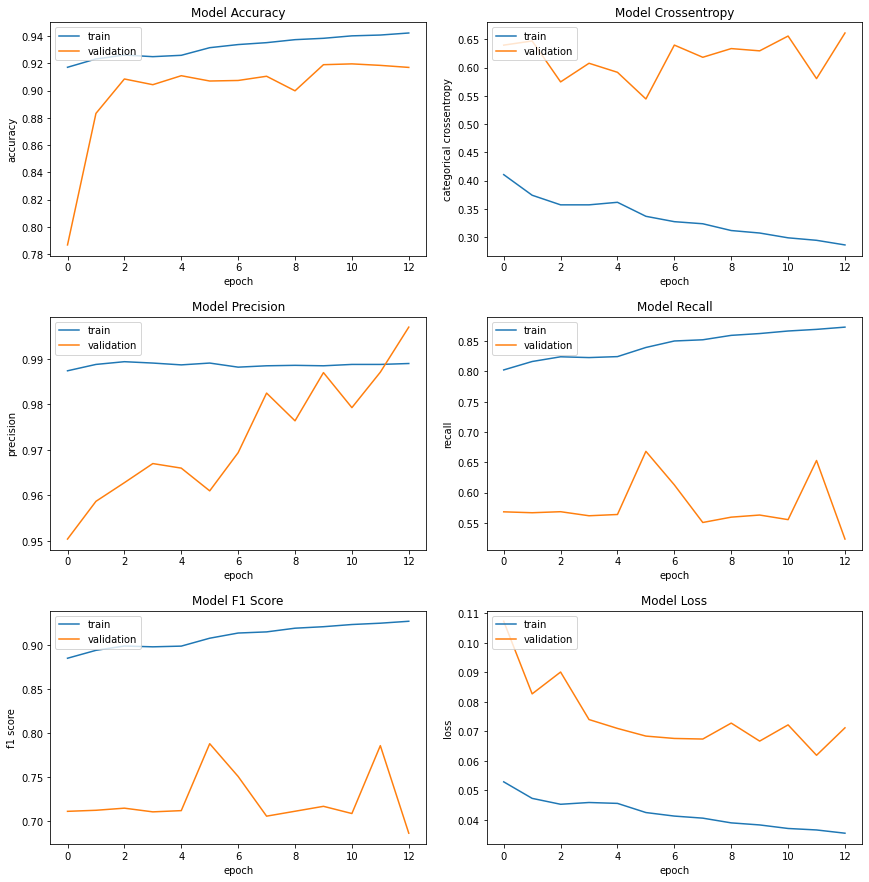

In [ ]:
# loading the json fil that contains the name and the path of the exported paches
model_history = '/content/drive/MyDrive/UNet_models/UNet_model_sig_foc_crossentropy_9/history.js'
with open(model_history) as j:
  full_model_hist = json.load(j)

fig, ax = plt.subplots(3, 2, figsize=(12, 12))
fig.tight_layout(w_pad=3, h_pad=4)

# Plotting history for accuracy
ax[0, 0].plot(full_model_hist['cat_acc'])
ax[0, 0].plot(full_model_hist['val_cat_acc'])
ax[0, 0].set_title('Model Accuracy')
ax[0, 0].set_ylabel('accuracy')
ax[0, 0].set_xlabel('epoch')
ax[0, 0].legend(['train', 'validation'], loc='upper left')

# Plotting history for categorical crossentropy
ax[0, 1].plot(full_model_hist['cat_xntrp'])
ax[0, 1].plot(full_model_hist['val_cat_xntrp'])
ax[0, 1].set_title('Model Crossentropy')
ax[0, 1].set_ylabel('categorical crossentropy')
ax[0, 1].set_xlabel('epoch')
ax[0, 1].legend(['train', 'validation'], loc='upper left')

# Plotting history for loss
ax[2, 1].plot(full_model_hist['loss'])
ax[2, 1].plot(full_model_hist['val_loss'])
ax[2, 1].set_title('Model Loss')
ax[2, 1].set_ylabel('loss')
ax[2, 1].set_xlabel('epoch')
ax[2, 1].legend(['train', 'validation'], loc='upper left')

# Plotting history for f1 score
ax[2, 0].plot(full_model_hist['f1_score'])
ax[2, 0].plot(full_model_hist['val_f1_score'])
ax[2, 0].set_title('Model F1 Score')
ax[2, 0].set_ylabel('f1 score')
ax[2, 0].set_xlabel('epoch')
ax[2, 0].legend(['train', 'validation'], loc='upper left')

# Plotting history for precision
ax[1, 0].plot(full_model_hist['prec'])
ax[1, 0].plot(full_model_hist['val_prec'])
ax[1, 0].set_title('Model Precision')
ax[1, 0].set_ylabel('precision')
ax[1, 0].set_xlabel('epoch')
ax[1, 0].legend(['train', 'validation'], loc='upper left')

# Plotting history for recall
ax[1, 1].plot(full_model_hist['rec'])
ax[1, 1].plot(full_model_hist['val_rec'])
ax[1, 1].set_title('Model Recall')
ax[1, 1].set_ylabel('recall')
ax[1, 1].set_xlabel('epoch')
ax[1, 1].legend(['train', 'validation'], loc='upper left')

## Load target keras model and make predictions
**Important Note**: It is advisable to only use this method of prediction if the target pacthes dataset is not too large. Here, the target data is made up of only 12 patches and it is there only for demonstrative purposes. It is very likely that Google Colab's memory allocation exceeds if the user tries to predict too many patches at once.

In [ ]:
folder = '/content/drive/MyDrive/UNet_models/UNet_model_sig_foc_crossentropy_9/'
model = folder + 'epochs:006.h5'
logs = folder + 'logs'
loaded_model = keras.models.load_model(model)
predictions = loaded_model.predict(predict_db)

# get total patches number
num_patches = pred_mixer['totalPatches']

# Getting the most likely class for each pixel
predicted_classes = [tf.argmax(predictions[i], 2).numpy() for i in range(num_patches)]#.T.argmax(0)

# Converting the input data into a numpy array (this take is very costly, so it
# is advisable to only use small patches number)
records = list(predict_db.as_numpy_iterator())
img = [records[i][0] for i in range(num_patches)]

## Visualise predicted patches (optional)

In [ ]:
# Keep the number of columns an even number to allow the images of patches to 
# be flanked by their mask. Please change these parameters according to your needs
rows = 3
cols = 8

# Here the Red, Yellow and Blue bands are in position 5, 4, 3 due to the bands
# distribution in the feature_dictionary outputted above. These will need to
# be changed if the user uses a different number of bands
if len(bands_of_interest) == 3:
  rgb_image = [np.stack([img[i][:,:,2],
                         img[i][:,:,1],
                         img[i][:,:,0]], axis=2) for i in range(num_patches)]

# Please modify the numbers within the square brackets to reflect the wanted
# bands for visualisation
else:
  rgb_image = [np.stack([img[i][:,:,5],
                         img[i][:,:,4],
                         img[i][:,:,3]], axis=2) for i in range(num_patches)]



In [ ]:
# Setting the plot size
fig, ax = plt.subplots(rows, cols, figsize=(36, 12))
fig.tight_layout(w_pad=1, h_pad=1)

# Plotting the target patches and the relative masks
count = 0
for i in range(rows):
  idx = count
  for j in range(cols):
    if j % 2 == 0:
      ax[i, j].imshow(rgb_image[idx]*5)
    else:
      ax[i, j].imshow(predicted_classes[idx])
      idx += 1
  count += int((cols/2))

Output hidden; open in https://colab.research.google.com to view.

# 4. Cross-validate predictions with GEE classifier
The predictions computed above are compared to the classification made in Google Earth Engine using a traditional classifier

## Generating a confusion matrix for each of the patches

In [ ]:
conf_matrix = [tf.math.confusion_matrix(labels=classes_db[i].flatten(),
                                        predictions=predicted_classes[i].flatten()) for i in range(num_patches)]

## Computing User and Producer accuracies for the entire scene

In [ ]:
# Generating a matrix of zeros to store the summations
sum_conf_matrices = np.zeros((conf_matrix[0].shape))

# Summing the confusion matrices
for matrix in conf_matrix:
  sum_conf_matrices += matrix

# List to store the values
sum_tot_user = []
sum_tot_prod = []
sum_user_acc = []
sum_prod_acc = []

# Computing the sum of values in each row and column
for k in range(conf_matrix[0].shape[0]):
  sum_tot_user.append(sum(sum_conf_matrices[k]))
  sum_tot_prod.append(sum([i[k] for i in sum_conf_matrices]))

# Computing the User and producer accuracies
for j in range(conf_matrix[0].shape[0]):
  sum_user_acc.append(round(
      float(sum_conf_matrices[j][j]/sum_tot_user[j]*100), 2))
  sum_prod_acc.append(round(
      float(sum_conf_matrices[j][j]/sum_tot_prod[j]*100), 2))

# checking if the summations are correct (hence, match)
assert sum(sum_tot_user) == sum(sum_tot_prod)

# output the values (Note: nans are to be considered zeros)
print('User Accuracies:', sum_user_acc)
print('\nProducer Accuracies:', sum_prod_acc)
print('\n\nSum Confusion Matrices:')
pprint(sum_conf_matrices)


User Accuracies: [4.38, 24.39, 0.0, 0.0, 52.91, 8.67, 49.33]

Producer Accuracies: [16.44, 36.12, nan, nan, 35.03, 0.55, 49.71]


Sum Confusion Matrices:
<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 4611, 23548,     0,     0, 35982, 21626, 19398],
       [10837, 55274,     0,     0, 72801, 51591, 36145],
       [ 1169,  6237,     0,     0,  9154,  5059,  6566],
       [ 1768, 10660,     0,     0, 14958,  8835,  9226],
       [ 6524, 27151,     0,     0, 95956, 30584, 21134],
       [  207,  3623,     0,     0,  1887,   789,  2598],
       [ 2930, 26547,     0,     0, 43218, 23853, 93986]], dtype=int32)>


## Computing User and Producer accuracies for each patch (Optional)

In [ ]:
# Generating lists to store the values
tot_user = [[] for i in range(num_patches)]
tot_prod = [[] for i in range(num_patches)]
user_acc = [[] for i in range(num_patches)]
prod_acc = [[] for i in range(num_patches)]

# Computing the sum of values in each row and column
for j in range(num_patches):
  for k in range(conf_matrix[0].shape[0]):
    tot_user[j].append(sum(conf_matrix[j][k]))
    tot_prod[j].append(sum([i[k] for i in conf_matrix[j]]))

# Computing the User and producer accuracies
for i in range(num_patches):
  for j in range(conf_matrix[0].shape[0]):
    user_acc[i].append(round(float(conf_matrix[i][j][j]/tot_user[i][j]*100), 2))
    prod_acc[i].append(round(float(conf_matrix[i][j][j]/tot_prod[i][j]*100), 2))

# checking if the summations are correct (hence, match)
assert sum(tot_user) == sum(tot_prod)

# output the values (Note: nans are to be considered zeros)
pprint(user_acc)
print('')
pprint(prod_acc)

# 5. Prepare predictions for export to Earth Engine
For this task the user **must** provide a Google Cloud Storage path. As explained above, Google Earth Engine can only convert TFRecords to assets if these are stored in Google Cloud Storage (Google Drive will not work for this task).

Please look at Google's documentation if in doubt: https://developers.google.com/earth-engine/guides/command_line#upload


In [ ]:
# user-defined parameters: please modify the following variables with your own
# Google Cloud Storage bucket and folders names
# ------------------------------------------------------------------------
predictions_folder = 'predicted_images'
predicted_image = 'UNet_sig_foc_crossentropy_9_006_img_2016'
out_predicted = 'gs://' + bucket + '/' + predictions_folder + '/' + predicted_image + '.TFRecord'

# Initiate the TFRecord writer on the target Google Cloud Storage 
writer = tf.io.TFRecordWriter(out_predicted)

# Writing predicted features to the target TFRecord. Since the predictions are in
# the order of the exported data, the patches will also follow the right ordering
patch_size = pred_mixer['patchDimensions'][0]
curPatch = 1
for  prediction in predictions:
  # Obtaining the most likely class for each pixel using argax()
  patch = prediction.squeeze().T.argmax(0).flatten().tolist()

  # ensuring that the predictions patch matches the expected length
  if (len(patch) == patch_size * patch_size):
    print('Done with patch ' + str(curPatch) + '...')  
  
    # Creating an Example, which will be the patch visualised in Earth Engine
    example = tf.train.Example(
      features = tf.train.Features(
        feature = {
          'prediction': tf.train.Feature(
              float_list = tf.train.FloatList(
                  value = patch))
        }
      )
    )

    # Converting the saved TFRecords to binary strings as expected by Earth Engine
    writer.write(example.SerializeToString())    
    curPatch += 1 

# Finishing the writing task
writer.close()

Done with patch 1...
Done with patch 2...
Done with patch 3...
Done with patch 4...
Done with patch 5...
Done with patch 6...
Done with patch 7...
Done with patch 8...
Done with patch 9...
Done with patch 10...
Done with patch 11...
Done with patch 12...


## Setup asset ID



In [ ]:
# user-defined parameters: please modify the following variables with your own
# Earth Engine username and wanted assed ID
# ------------------------------------------------------------------------
username = 'davidelomeo'
outputAssetID = 'users/' + username + '/' + predicted_image
print('Writing to ' + outputAssetID)

Writing to users/davidelomeo/UNet_sig_foc_crossentropy_9_006_img_2016


## Generate Eath Engine Asset

In [ ]:
# Uploading the records to Earth Egnine as an asset. This action may take a
# while if the predicted area is large.
!earthengine upload image --asset_id={outputAssetID} {out_predicted} {pred_json}

# 5. Visualise predicted patches on Earth Engine
Loading the asset exported to Earth Engine and output it using the original classification palette used in Notebook 1

In [ ]:
# Loading a pre-defined Southeast Asia area of interest. This variable is not
# necessary but useful for delimiting the geographical area to Southeas Asia.
ROI = ee.FeatureCollection('users/davidelomeo/acse9_final_project/SEA')

# Setting the start and end dates
start_date = ee.Date.fromYMD(2016,1,1)
end_date = ee.Date.fromYMD(2016, 12,31)

# Loading the images for the selected period and bouding them to the target ROI.
# The images are pre-filtered to only get those with maximum 30% of cloud cover
# to reduce the cloud masking effect on the images.
image_collection = ee.ImageCollection('COPERNICUS/S2') \
                     .filterDate(start_date, end_date) \
                     .filterBounds(ROI) \
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
                     .map(ct.mask_sentinel_clouds)

# Getting spectral indices for the median image and clipping to ROI. The median
# pixel value was preferred from the mean to avoid potential skeweness in the 
# pixels values distribution
median_image = image_collection.median().clip(ROI)

# Creating a separate image for RGB visualisation
rgb_image = median_image.select(['B2', 'B3', 'B4'])

In [ ]:
# Loading the asset previously exported to Earth Engine.
# Please change the path and name of the asset accordignly.
probs_image = ee.Image('users/davidelomeo/UNet_sig_foc_crossentropy_9_006_img_2016')

RGB = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2']}

# Creating colour palette for the target classes
legend_dict = {
    'Delta': '80D604', 
    'Estuary': '01BD7C', 
    'Lagoon': '36DFFF', 
    'OpenCoast': 'DEFF00', 
    'Water': '0050D5', 
    'NonMangroves': '106703', 
    'Other': 'B06F03'
}

Map = geemap.Map()
Map.centerObject(probs_image, 14)
Map.addLayer(rgb_image, RGB, 'RGB Image')
Map.addLayer(probs_image, 
             {'min': 0, 'max': 6, 
              'palette': [v for v in legend_dict.values()]},
              'Classification 2016', opacity=0.5)
Map.add_legend(title='Legend', legend_dict=legend_dict)
Map